# Fairness in AI: Removing word embeddings

#### Kylian van Geijtenbeek, Thom Visser, Martine Toering, Iulia Ionescu

$\textbf{Abstract:}$ In this paper we reproduce the word embedding debiasing algorithm from Bolukbasi et al. [2]. We adapt the available implementation and extend it with their soft debiasing method. We integrate several popular benchmarks and investigate the effectiveness of the algorithm on GloVe and fastText embeddings besides the Word2vec embeddings used by Bolukbasi et al. [2]. We show that the removal of direct bias from all the different embeddings barely affects their effectiveness through a comparison of benchmark scores. However, we fail to reproduce the large scale soft debiasing results due to a lack of detail on the original implementation.

In [1]:
from __future__ import print_function, division
%matplotlib inline
from matplotlib import pyplot as plt
import json
import random
import numpy as np
import copy

import debiaswe as dwe
import debiaswe.we as we
from debiaswe.we import WordEmbedding
from debiaswe.data import *

from debiaswe.debias import *
from debiaswe.benchmarks import Benchmark

from compare_bias import *

## Notebook preferences

# 1 - Gender Bias in word2vec, Glove and FastText

### Load data

In this notebook, we will use three different word embeddings: $\textbf{word2vec}$ (Mikolov et al. 2013), $\textbf{glove}$ (Pennington et al. 2014) and $\textbf{fastText}$ (Bojanowski et al. 2016).

The word2vec embedding we use is learned from a corpus of Google News articles (https://code.google.com/archive/p/word2vec/). The embeddings are 300-dimensional for 3 million words. For glove we make use of the 300-dimensional vectors trained on Common Crawl (https://nlp.stanford.edu/projects/glove/). Lastly, FastText is a word embedding from Facebook AI Research lab trained on Wikipedia corpus and Common Crawl and also consists of 300-dimensional vectors (https://fasttext.cc/docs/en/english-vectors.html).

We start by loading in the data.

In [2]:
# Load google news word2vec
E = WordEmbedding("word2vec_small")
# Load debiased word2vec
E_hard = WordEmbedding("word2vec_small_hard_debiased")
E_soft = WordEmbedding("word2vec_small_soft_debiased")

26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine
Embedding shape: (26423, 300)
26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine
Embedding shape: (26423, 300)
26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine
Embedding shape: (26423, 300)


In [3]:
# Load Glove
E_g = WordEmbedding("glove_small")
E_g_hard = WordEmbedding("glove_small_hard_debiased")
E_g_soft = WordEmbedding("glove_small_soft_debiased")


# Load FastText 
E_f = WordEmbedding("fasttext_small")
E_f_hard = WordEmbedding("fasttext_small_hard_debiased")
E_f_soft = WordEmbedding("fasttext_small_soft_debiased")

42982 words of dimension 300 : the, and, to, of, ..., cushman, darkside, motherland, chairmen
Embedding shape: (42982, 300)
42982 words of dimension 300 : the, and, to, of, ..., cushman, darkside, motherland, chairmen
Embedding shape: (42982, 300)
42982 words of dimension 300 : the, and, to, of, ..., cushman, darkside, motherland, chairmen
Embedding shape: (42982, 300)
27014 words of dimension 300 : the, and, of, to, ..., circumscribed, whos, salvaging, anion
Embedding shape: (27014, 300)
27014 words of dimension 300 : the, and, of, to, ..., circumscribed, whos, salvaging, anion
Embedding shape: (27014, 300)
27014 words of dimension 300 : the, and, of, to, ..., circumscribed, whos, salvaging, anion
Embedding shape: (27014, 300)


## Word2vec

In [4]:
# Load professions and gender related lists from Bolukbasi et al. for word2vec

gender_seed, defs, equalize_pairs, profession_words = load_data(E.words)

### Define gender direction

We define the gender direction by either PCA or by the words "she" and "he" for word2vec.

In [5]:
# Define gender direction with the words "she" and "he" 
# v_gender = E.diff('she', 'he')

# Define gender direction with PCA
v_gender = we.doPCA(defs, E).components_[0]

### Generating analogies


Below, we show some of the gender analogies that we can create from the embeddings. TODO

In [6]:
# Analogies gender
a_gender = E.best_analogies_dist_thresh(v_gender, thresh=1)
we.viz(a_gender)

Computing neighbors
Mean: 10.219732808538016
Median: 7.0
(135018, 300)
   0                      herself | himself                      0.94
   1                          she | he                           0.94
   2                          her | his                          0.91
   3                        woman | man                          0.82
   4                     daughter | son                          0.74
   5                         girl | boy                          0.74
   6                      actress | actor                        0.72
   7                businesswoman | businessman                  0.70
   8                       sister | brother                      0.69
   9                       mother | father                       0.69
  10                  spokeswoman | spokesman                    0.67
  11                      heroine | hero                         0.67
  12                   chairwoman | chairman                     0.67
  13               

### Analyzing occupational gender bias 


In [7]:
# Analysis of extreme male and extreme female professions
sp = E.profession_stereotypes(profession_words, v_gender)

                Female                |                 Male                 
-----------------------------------------------------------------------------
0.38                    businesswoman | maestro                        -0.244
0.379                         actress | protege                        -0.236
0.378                       housewife | statesman                      -0.222
0.323                       homemaker | businessman                    -0.219
0.308                           nurse | sportsman                      -0.209
0.302                registered_nurse | philosopher                    -0.196
0.297                        waitress | marksman                       -0.192
0.28                     receptionist | skipper                        -0.187
0.278                       socialite | financier                      -0.183
0.277                       librarian | architect                      -0.177
0.272                            maid | magician                

## fastText

In [8]:
# Load professions and gender related lists from Bolukbasi et al. for fastText
gender_seed, defs, equalize_pairs, profession_words = load_data(E_f.words)

### Define gender direction

We define the gender direction by either PCA or by the words "she" and "he" for fastText.

In [9]:
# Define gender direction with the words "she" and "he" 
# v_gender = E_f.diff('she', 'he')

# Define gender direction with PCA
v_gender = we.doPCA(defs, E_f).components_[0]

### Generating analogies


In [10]:
# Analogies gender
a_gender = E_f.best_analogies_dist_thresh(v_gender, thresh=1)
we.viz(a_gender)

Computing neighbors
Mean: 95.97786333012512
Median: 53.0
(1296373, 300)
   0                      herself | himself                      0.95
   1                          she | he                           0.93
   2                          her | his                          0.91
   3                        woman | man                          0.71
   4                         shes | hes                          0.70
   5                         girl | boy                          0.67
   6                businesswoman | businessman                  0.64
   7                  spokeswoman | spokesman                    0.63
   8                      actress | actor                        0.63
   9                      heroine | hero                         0.62
  10                   chairwoman | chairman                     0.61
  11                   motherhood | fatherhood                   0.59
  12                          gal | guy                          0.59
  13              

### Analyzing occupational gender bias 


In [11]:
# Analysis of extreme male and extreme female professions
sp = E_f.profession_stereotypes(profession_words, v_gender)

                Female                |                 Male                 
-----------------------------------------------------------------------------
0.278                   businesswoman | maestro                        -0.187
0.258                         actress | salesman                       -0.178
0.214                             nun | sportsman                      -0.173
0.19                            nurse | inventor                       -0.166
0.187                       housewife | businessman                    -0.159
0.176                       socialite | barber                         -0.148
0.17                         waitress | statesman                      -0.144
0.169                            maid | pundit                          -0.14
0.159                       ballerina | carpenter                      -0.136
0.12                      housekeeper | headmaster                     -0.131
0.111                    receptionist | janitor                 

# 2 - Comparing Bias of word2vec, Glove and FastText

We will compare the gender bias between word embeddings FastText and Glove. We do this by following Bolukbasi et al. approach on figure 4 in their paper. The profession words are projected onto the gender axis for FastText and Glove. Each datapoint represents a profession word.

Below we compare the bias of embeddings Word2vec and fastText.

                Female                |                 Male                 
-----------------------------------------------------------------------------
                Female                |                 Male                 
-----------------------------------------------------------------------------


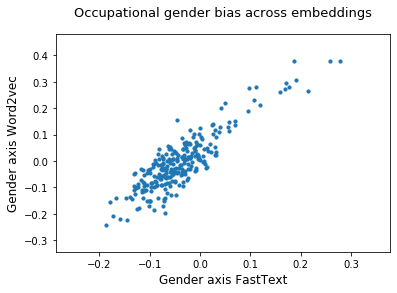

In [12]:
compare_occupational_bias(E, E_f, ["Word2vec", "FastText"])

                Female                |                 Male                 
-----------------------------------------------------------------------------
                Female                |                 Male                 
-----------------------------------------------------------------------------


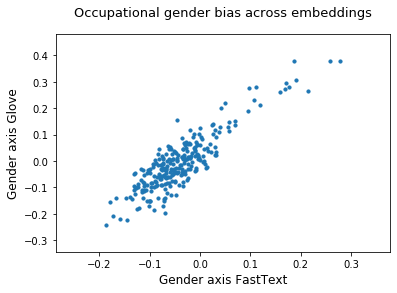

In [13]:
compare_occupational_bias(E, E_f, ["Glove", "FastText"])

# 3 - Debiasing algorithms on word2vec, Glove and FastText

## Hard debiasing

In hard debiasing, the gender neutral words are shifted to zero in the gender subspace (i.e. neutralized) by subtracting the projection of the neutral word embedding vector onto the gender subspace and renormalizing the resulting embedding to unit length. 

## Soft debiasing

We adapted specifics from Manzini et al., Soft debiasing is done by solving the following optimization problem as mentioned in their paper:

\begin{equation}
    \underset{T}{\min} || (TW)^T(TW) - W^TW||^2_F + \lambda ||(TN)^T (TB)||^2_F
\end{equation}

where W is the matrix of all embedding vectors, N is the matrix of the embedding vectors of the gender neutral words, B is the gender subspace, and T is the debiasing transformation that minimizes the projection of the neutral words onto the gender subspace but tries to maintain the pairwise inner products between the words.

This code is largely based on code from https://github.com/TManzini/DebiasMulticlassWordEmbedding.

### Hard debiasing Word2vec
First, we show the effect of hard debiasing on Word2vec.

In [14]:
# Hard debiased Word2vec
# Analysis of extreme male and extreme female professions
sp_hard_debiased = E_hard.profession_stereotypes(profession_words, v_gender)

                Female                |                 Male                 
-----------------------------------------------------------------------------
0.172                       barrister | provost                        -0.128
0.157                      magistrate | acquaintance                   -0.119
0.151                      adventurer | president                      -0.116
0.15                       naturalist | employee                       -0.111
0.148                          warden | ambassador                     -0.105
0.143                       policeman | housekeeper                    -0.097
0.136                       solicitor | educator                        -0.09
0.135                 cinematographer | dean                           -0.084
0.127                             cop | janitor                        -0.084
0.125                      campaigner | congressman                    -0.084
0.121                        minister | rabbi                   

In [15]:
# Analogies gender
a_gender_hard_debiased = E_hard.best_analogies_dist_thresh(v_gender)
we.viz(a_gender_hard_debiased)

Computing neighbors
Mean: 10.218597434053665
Median: 7.0
(135003, 300)
   0                        tonne | metric_tons                  0.25
   1                     sizeable | sizable                      0.25
   2                        group | organization                 0.25
   3                     wildlife | endangered_species           0.24
   4                    agreeable | amicable                     0.24
   5                 ridiculously | unbelievably                 0.24
   6                        banks | institutions                 0.24
   7                        birds | nest                         0.24
   8                       petrol | gasoline                     0.24
   9                       prints | artwork                      0.24
  10                    confesses | confided                     0.23
  11                      deficit | budget_shortfalls            0.23
  12                 masterminded | orchestrated                 0.23
  13               

# 4 - Benchmarks

TODO text

In [16]:
def run_benchmark(benchmark, E, E_hard, E_soft, embedding_name):
    result_original = benchmark.evaluate(E, "'Before', {}".format(embedding_name))
    result_hard_debiased = benchmark.evaluate(E_hard, "'Hard debiased', {}".format(embedding_name))
    result_soft_debiased = benchmark.evaluate(E_soft, "'Soft debiased', {}".format(embedding_name))
    results = [result_original, result_hard_debiased, result_soft_debiased]
    return results

### Word2vec

Below, we show the benchmarks for Word2vec.

In [17]:
# Evaluate for word2vec
benchmark = Benchmark()
w2v_results = run_benchmark(benchmark, E, E_hard, E_soft, "word2vec")
benchmark.pprint_compare(w2v_results, ["Before", "Hard-debiased", "Soft-debiased"], "word2vec")

+-------------------------------------------------------+
|             Results for 'Before', word2vec            |
+---------------+-------+-----------+-------------------+
| Dataset       | Found | Not Found |       Score       |
+---------------+-------+-----------+-------------------+
| EN-WS-353-ALL |  318  |     35    | 68.82719646959825 |
| EN-RG-65      |   53  |     12    | 77.66555804950227 |
| MSR-analogy   |  5276 |    2724   | 46.79681576952237 |
| WEAT          |   -   |     -     |      1.488202     |
+---------------+-------+-----------+-------------------+
+--------------------------------------------------------+
|         Results for 'Hard debiased', word2vec          |
+---------------+-------+-----------+--------------------+
| Dataset       | Found | Not Found |       Score        |
+---------------+-------+-----------+--------------------+
| EN-WS-353-ALL |  318  |     35    | 68.52623098234018  |
| EN-RG-65      |   53  |     12    | 77.49622028082247  |
| MSR-a

### Glove and FastText

In [18]:
# Glove and FastText

g_results = run_benchmark(benchmark, E_g, E_g_hard, E_g_soft, "Glove")
benchmark.pprint_compare(g_results, ["Before", "Hard-debiased", "Soft-debiased"], "Glove")


f_results = run_benchmark(benchmark, E_f, E_f_hard, E_f_soft, "fastText")
benchmark.pprint_compare(f_results, ["Before", "Hard-debiased", "Soft-debiased"], "fastText")

+-------------------------------------------------------+
|              Results for 'Before', Glove              |
+---------------+-------+-----------+-------------------+
| Dataset       | Found | Not Found |       Score       |
+---------------+-------+-----------+-------------------+
| EN-WS-353-ALL |  330  |     23    | 66.43748693628271 |
| EN-RG-65      |   62  |     3     | 83.10311410756115 |
| MSR-analogy   |  5380 |    2620   | 37.47211895910781 |
| WEAT          |   -   |     -     |     1.6407514     |
+---------------+-------+-----------+-------------------+
+-------------------------------------------------------+
|           Results for 'Hard debiased', Glove          |
+---------------+-------+-----------+-------------------+
| Dataset       | Found | Not Found |       Score       |
+---------------+-------+-----------+-------------------+
| EN-WS-353-ALL |  330  |     23    | 66.61161322854848 |
| EN-RG-65      |   62  |     3     | 83.35243100494134 |
| MSR-analogy 